# Deep Learning
## Exercise Sheet 05 - MNIST mit CNN
### Prof. Dr. David Spieler
### david.spieler@hm.edu
### University of Applied Sciences Munich
#### adapted from https://www.kaggle.com/code/geekysaint/solving-mnist-using-pytorch

In [56]:
import torch
import torch.nn as nn
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt

## 1. Loading MNIST dataset

In [57]:
# Load the data set (download if neccessary) and while loading the pixel data transform
# to a PyTorch tensor
mnist_dataset = MNIST(root = 'data/', train = True, transform = transforms.ToTensor())

Label: 5


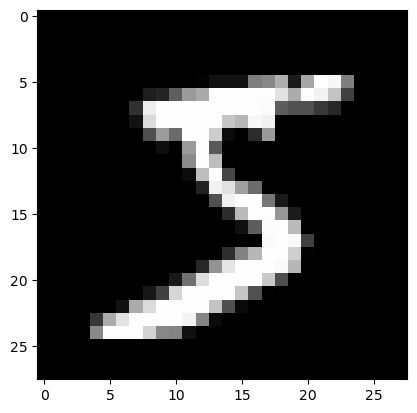

In [58]:
# Extract the first image
image_tensor, label = mnist_dataset[0]
print('Label:', label)
# Plot the image of the tensor - first dimension only has one value 0 since we only have
# a single pixel plane (gray scale)
plt.imshow(image_tensor[0,:,:],cmap = 'gray')

### Question: What does the data look like?
The data consists of 28x28 gray scale images of handwritten letters from 0 to 9.

## 2. Split the data into train and test batches

In [59]:
# split the 60k images into 50k training and 10k test images
train, test = random_split(mnist_dataset, [50000, 10000]) 

In [60]:
# split the respective data sets further into batches of size batch_size
batch_size = 128
# enable dynamically loading images from the respective sets into batches
train_loader = DataLoader(train, batch_size, shuffle = True) # randomize for training
test_loader = DataLoader(test, batch_size, shuffle = False)  # static for testing

## 3. Build the model

In [61]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.out = nn.Sequential(
            nn.Conv2d(1, 32, 3),                              
            nn.ReLU(),                      
            nn.MaxPool2d(2), 

            nn.Conv2d(32, 64, 3),     
            nn.ReLU(),                      
            nn.MaxPool2d(2), 
            
            nn.Dropout(0.5),
            nn.Flatten(1),
            nn.Linear(64 * 5 * 5, 10)
        )
        
    def forward(self, x):
        return self.out(x)

### Question: What does the model look like?

In [62]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return(torch.tensor(torch.sum(preds == labels).item()/ len(preds)))
    
def apply_batch(model, batch):
    images, labels = batch
    out = model(images) # generate predictions
    loss = F.cross_entropy(out, labels) # calculate the loss
    acc = accuracy(out, labels) # calculate accuracy
    return (loss, acc)
    
def compute_loss_acc(outputs):
    batch_losses = [loss for loss,acc in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [acc for loss,acc in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return(epoch_loss.item(), epoch_acc.item())

In [63]:
model = MnistModel()

## 4. Train the model

In [64]:
def fit(epochs, lr, model, train_loader, test_loader, opt_func = torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        
        # training
        result_train = []
        for batch in train_loader:
            loss, acc = apply_batch(model, batch)
            loss.backward()
            result_train.append((loss, acc))
            optimizer.step()
            optimizer.zero_grad()
        
        # testing
        result_test = [apply_batch(model, batch) for batch in test_loader]

        train_loss, train_acc = compute_loss_acc(result_train)
        test_loss, test_acc = compute_loss_acc(result_test)
        
        print("Epoch #{}, train_loss: {:.4f}, train_acc: {:.4f}, test_loss: {:.4f}, test_acc: {:.4f}".format(epoch, train_loss, train_acc, test_loss, test_acc))
        
        history.append((train_loss, train_acc, test_loss, test_acc))
    return(history)

In [65]:
history = fit(15, 0.001, model, train_loader, test_loader)

Epoch #0, train_loss: 0.3454, train_acc: 0.8961, test_loss: 0.1373, test_acc: 0.9598
Epoch #1, train_loss: 0.1110, train_acc: 0.9658, test_loss: 0.0948, test_acc: 0.9716
Epoch #2, train_loss: 0.0848, train_acc: 0.9742, test_loss: 0.0830, test_acc: 0.9738
Epoch #3, train_loss: 0.0737, train_acc: 0.9769, test_loss: 0.0859, test_acc: 0.9745
Epoch #4, train_loss: 0.0628, train_acc: 0.9805, test_loss: 0.0648, test_acc: 0.9808
Epoch #5, train_loss: 0.0587, train_acc: 0.9819, test_loss: 0.0632, test_acc: 0.9801
Epoch #6, train_loss: 0.0532, train_acc: 0.9833, test_loss: 0.0591, test_acc: 0.9823
Epoch #7, train_loss: 0.0493, train_acc: 0.9849, test_loss: 0.0558, test_acc: 0.9826
Epoch #8, train_loss: 0.0474, train_acc: 0.9841, test_loss: 0.0580, test_acc: 0.9833
Epoch #9, train_loss: 0.0439, train_acc: 0.9862, test_loss: 0.0527, test_acc: 0.9840
Epoch #10, train_loss: 0.0429, train_acc: 0.9867, test_loss: 0.0536, test_acc: 0.9836
Epoch #11, train_loss: 0.0384, train_acc: 0.9880, test_loss: 0.0

## 5. Evaluate the model

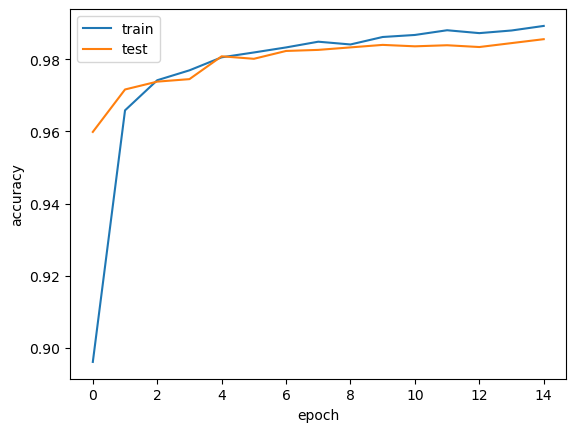

In [66]:
test_accuracies = [test_acc for train_loss, train_acc, test_loss, test_acc in history]
train_accuracies = [train_acc for train_loss, train_acc, test_loss, test_acc in history]

plt.plot(train_accuracies)
plt.plot(test_accuracies)

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','test'])

### Question: Does the plot look like a normal learning curve?
The plot does not look like an ordinary learning curve since initially, the test accuracy already is higher than the train accuracy. But at least there is no direct sign of overfitting.